In [1]:
from models.MTL_IBA import MTL_IBA, MTL_IBA_h3, MTL_IBA_cross, MTL_IBA_cross2, MTL_IBA_cross3
from models.MLT_net import MTL_classic
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.models import load_model, Model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib as mpl
from keras import backend as K
import numpy as np
import cv2



import os


# weight_path = 'MTL_IBA_cross3_256.h5'

# base_model = MTL_IBA_cross3(256, 256, 3, nClasses=2)
# # model = MTL_IBA_cross(img_size, img_size, depth, nClasses=2)
# # model = MTL_IBA_cross2(img_size, img_size, depth, nClasses=2)
# # model = MTL_IBA_cross3(img_size, img_size, depth, nClasses=2)

# base_model.load_weights(weight_path, by_name=True)
# base_model.summary()



Using TensorFlow backend.
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
def load_img_preprocess(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img = image.img_to_array(img) 
    img = np.expand_dims(img, axis=0) # 
#     img = preprocess_input(img)
    img = to_unit_interval(img) #
    return img


def grad_cam(model, img):
  
    preds = model.predict(img)
    num = np.argmax(preds[0]) #
    
    model2 = Model(inputs=model.input, outputs=model.get_layer('block5_c_conv3').output)

    output = model2.output[0][:, num]
    last_layer = model2.get_layer('block5_c_conv3')
    grads = K.gradients(output, last_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2)) #
    iterate = K.function([model2.input], [pooled_grads, last_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([img])

    for i in range(pooled_grads.shape[0]):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    return conv_layer_output_value

    
def plot_heatmap(conv_layer_output_value, img_in_path, img_out_path):
    

    mean = np.mean(conv_layer_output_value, axis=0)
    maxi = np.max(conv_layer_output_value)
    mini = np.min(conv_layer_output_value)
    conv_layer_output_value = (conv_layer_output_value - mean)/(maxi-mini)
#     conv_layer_output_value = (conv_layer_output_value - mean)
    heatmap = np.mean(conv_layer_output_value,axis = -1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= float(np.log(2))
    heatmap = heatmap / np.max(heatmap)
    
    
    from PIL import Image
    img = Image.open(img_in_path)
    img_np = np.array(img)
    dpi = 100
    fig = plt.figure(frameon=False)
#     fig.set_size_inches(img_np.shape[1] / dpi, img_np.shape[0] / dpi)
    heatmap = cv2.resize(heatmap, (224, 224))
    fig.set_size_inches(224 / dpi, 224 / dpi)
#     plt.imshow(img)
    
#     heatmap = cv2.resize(heatmap, (img_np.shape[1], img_np.shape[0]))
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    
    #  定义颜色 color map
    vmax = heatmap.max()
    norm = mpl.colors.Normalize(vmin=0, vmax=vmax)
    n = 255
    half_jet_rgba = plt.cm.seismic(np.linspace(0.5, 1, n))
    half_jet_rgba[:, -1] = np.linspace(0.2, 1, n)
    cmap = mpl.colors.ListedColormap(half_jet_rgba)
    hmap_jet = cmap(norm(heatmap))
    

    min_alpha=0.2
    max_alpha=0.6
    if img is not None:
        hmap_jet[:, :, -1] = (max_alpha - min_alpha)*norm(heatmap) + min_alpha
 
    plt.axis('off')
    plt.imshow(hmap_jet, alpha=1, cmap=cmap) # alpha设置透明度, cmap可以选择颜色
#     plt.savefig(img_out_path)
    fig.savefig(img_out_path, dpi=dpi, bbox_inches='tight', pad_inches = -0.1)
    print(img_out_path)
    
    
def to_unit_interval(x):
    """Scales ``x`` to be in ``[0, 1]``."""
    return (x - x.min()) / (x.max() - x.min())
    

In [3]:
def plot_dict_img_heatmap(testX_dir, save_dir, model):
    
    class_list = os.listdir(testX_dir)
    for class_name in class_list:
        class_path = os.path.join(testX_dir, class_name)
        img_list = os.listdir(class_path)
        for image_Name in img_list:
            
            img_path = os.path.join(class_path, image_Name)
            print(img_path)
            img_out_path = os.path.join(save_dir, image_Name)
            
            img = load_img_preprocess(img_path, (img_size, img_size))
            conv_value = grad_cam(model, img)
            plot_heatmap(conv_value, img_path, img_out_path)
            


In [4]:
import os
from models.MTL_IBA import MTL_IBA, MTL_IBA_h3, MTL_IBA_cross, MTL_IBA_cross2, MTL_IBA_cross3
from models.MLT_net import MTL_classic
from models.MTL_Attention import MTL_Attention_model

Name = 'Grad-CAM'
img_size =224
depth = 3
testX_dir = 'dataset/Dataset_BUSI_AN/test/images/'
save_dir = 'dataset/prediction/Dataset_BUSI_AN/' + Name
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
    

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
   
model = MTL_IBA_cross3(img_size, img_size, depth, nClasses=2)
# model = MTL_Attention_model(img_size, img_size, depth, nClasses=2)
model.load_weights('MTL-IBA.h5', by_name=True)

Instructions for updating:
Colocations handled automatically by placer.
lamb################################# Tensor("iba/Sigmoid:0", shape=(1, 28, 28, 256), dtype=float32)
Z_with_passing################################# Tensor("iba/mul_6:0", shape=(?, 28, 28, 256), dtype=float32)
output################################# Tensor("iba/cond_2/Merge:0", shape=(?, 28, 28, 256), dtype=float32)


2022-04-21 11:53:15.674147: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-04-21 11:53:15.709270: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2200095000 Hz
2022-04-21 11:53:15.713725: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x6ec9e20 executing computations on platform Host. Devices:
2022-04-21 11:53:15.713816: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>
2022-04-21 11:53:16.227202: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x6f75e60 executing computations on platform CUDA. Devices:
2022-04-21 11:53:16.227335: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2022-04-21 11:53:16.229037: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1433] Found device 0 with properties: 
name: Tes

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


dataset/Dataset_BUSI_AN/test/images/bengin_images/benign (51).png
dataset/prediction/Dataset_BUSI_AN/Grad-CAM/benign (51).png
dataset/Dataset_BUSI_AN/test/images/bengin_images/benign (299).png
dataset/prediction/Dataset_BUSI_AN/Grad-CAM/benign (299).png
dataset/Dataset_BUSI_AN/test/images/bengin_images/benign (167).png
dataset/prediction/Dataset_BUSI_AN/Grad-CAM/benign (167).png
dataset/Dataset_BUSI_AN/test/images/bengin_images/benign (220).png
dataset/prediction/Dataset_BUSI_AN/Grad-CAM/benign (220).png
dataset/Dataset_BUSI_AN/test/images/bengin_images/benign (297).png
dataset/prediction/Dataset_BUSI_AN/Grad-CAM/benign (297).png
dataset/Dataset_BUSI_AN/test/images/bengin_images/benign (425).png
dataset/prediction/Dataset_BUSI_AN/Grad-CAM/benign (425).png
dataset/Dataset_BUSI_AN/test/images/bengin_images/benign (57).png
dataset/prediction/Dataset_BUSI_AN/Grad-CAM/benign (57).png
dataset/Dataset_BUSI_AN/test/images/bengin_images/benign (38).png
dataset/prediction/Dataset_BUSI_AN/Grad-CA

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


dataset/prediction/Dataset_BUSI_AN/Grad-CAM/benign (231).png
dataset/Dataset_BUSI_AN/test/images/bengin_images/benign (127).png
dataset/prediction/Dataset_BUSI_AN/Grad-CAM/benign (127).png
dataset/Dataset_BUSI_AN/test/images/bengin_images/benign (21).png
dataset/prediction/Dataset_BUSI_AN/Grad-CAM/benign (21).png
dataset/Dataset_BUSI_AN/test/images/bengin_images/benign (150).png
dataset/prediction/Dataset_BUSI_AN/Grad-CAM/benign (150).png
dataset/Dataset_BUSI_AN/test/images/bengin_images/benign (315).png
dataset/prediction/Dataset_BUSI_AN/Grad-CAM/benign (315).png
dataset/Dataset_BUSI_AN/test/images/bengin_images/benign (104).png
dataset/prediction/Dataset_BUSI_AN/Grad-CAM/benign (104).png
dataset/Dataset_BUSI_AN/test/images/bengin_images/benign (142).png
dataset/prediction/Dataset_BUSI_AN/Grad-CAM/benign (142).png
dataset/Dataset_BUSI_AN/test/images/bengin_images/benign (119).png
dataset/prediction/Dataset_BUSI_AN/Grad-CAM/benign (119).png
dataset/Dataset_BUSI_AN/test/images/bengin_im

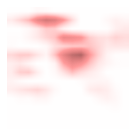

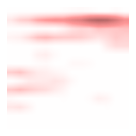

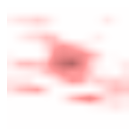

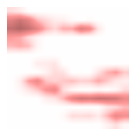

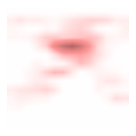

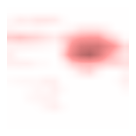

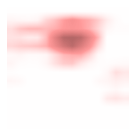

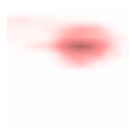

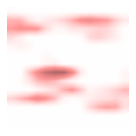

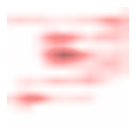

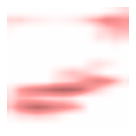

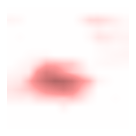

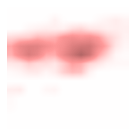

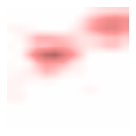

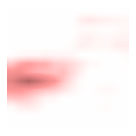

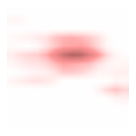

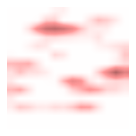

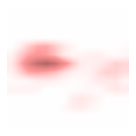

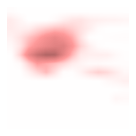

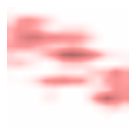

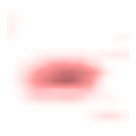

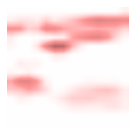

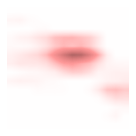

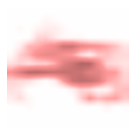

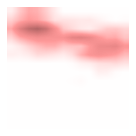

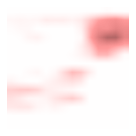

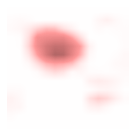

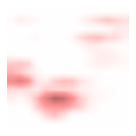

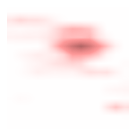

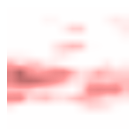

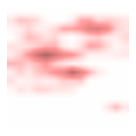

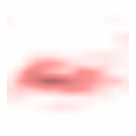

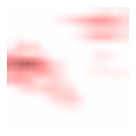

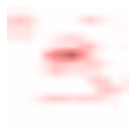

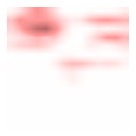

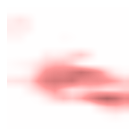

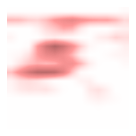

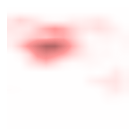

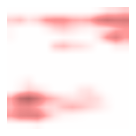

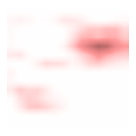

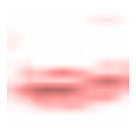

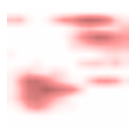

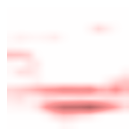

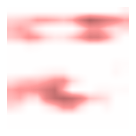

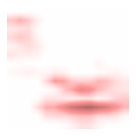

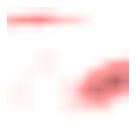

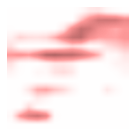

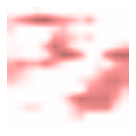

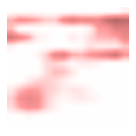

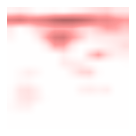

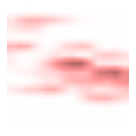

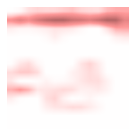

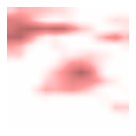

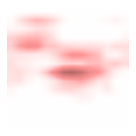

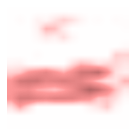

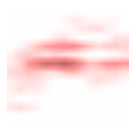

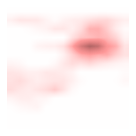

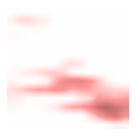

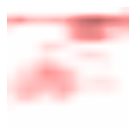

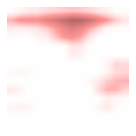

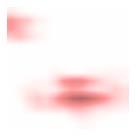

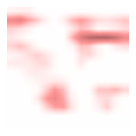

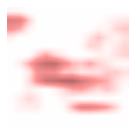

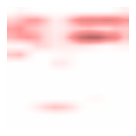

In [6]:
save_dir = 'dataset/prediction/Dataset_BUSI_AN/Grad-CAM'

plot_dict_img_heatmap(testX_dir, save_dir, model)  